## Import Library

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud


## Eksplorasi Data

In [103]:
# Baca dataset
df = pd.read_csv('dataset/reviews.csv')

# Lihat struktur data
print(df.shape)
df.head()


(3000, 4)


,userName,score,content,at
0,Meilinda sari,5,memang sangat d perlukan tp pastikan BMKG haru...,2025-05-26 05:24:01
1,Sarman Simamora,5,membantu mengetahui keadaan cuaca,2025-05-25 14:32:44
2,lilik putut armunanto lilik,5,Good,2025-05-25 11:23:59
3,imam tirta,5,membantu sekali,2025-05-25 10:28:27
4,Andhez Nikko,5,cukup membantu,2025-05-25 06:55:58


#### Score

In [104]:
df['score'].value_counts().sort_index()


score
1     435
2     225
3     315
4     300
5    1725
Name: count, dtype: int64

#### Lebel

In [105]:
def label_sentiment(score):
    if score <= 2:
        return 'negatif'
    elif score == 3:
        return 'netral'
    else:
        return 'positif'

df['label'] = df['score'].apply(label_sentiment)
df['label'].value_counts()


label
positif    2025
negatif     660
netral      315
Name: count, dtype: int64

#### Membersihkan Teks

In [106]:
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'\n', ' ', text)  # hapus newline
    text = re.sub(r'http\S+', '', text)  # hapus link
    text = re.sub(r'\d+', '', text)  # hapus angka
    text = text.translate(str.maketrans('', '', string.punctuation))  # hapus tanda baca
    text = text.strip()
    return text

df['clean_content'] = df['content'].astype(str).apply(clean_text)


In [107]:
nltk.download('stopwords')
stopwords_ind = stopwords.words('indonesian')

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords_ind])

df['clean_content'] = df['clean_content'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to C:\Users\Yoga
[nltk_data]     Samudra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [108]:
# Ambil kolom teks & label
X = df['clean_content']
y = df['label']

# Split ke training & testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [109]:
# Buat TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Transform data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


#### Visualisasi

**Lebel Sentimen**

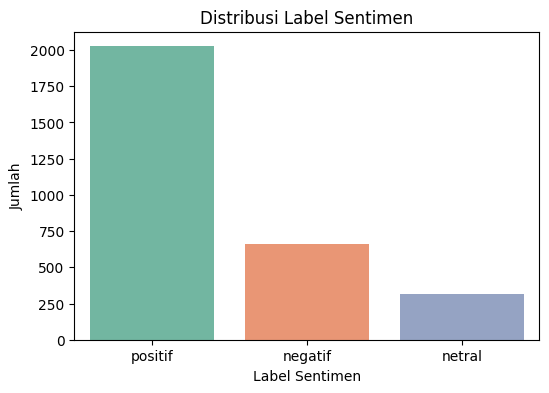

In [110]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', hue='label', palette='Set2', dodge=False, legend=False, order=df['label'].value_counts().index)

plt.title('Distribusi Label Sentimen')
plt.xlabel('Label Sentimen')
plt.ylabel('Jumlah')
plt.show()


**Skor Ulasan**

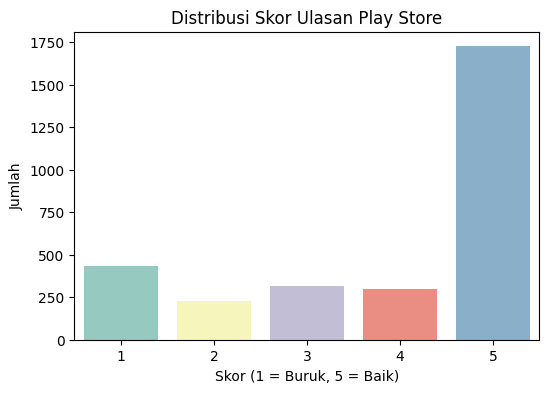

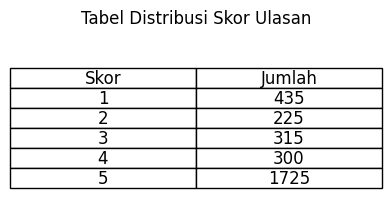

In [111]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='score', hue='score', palette='Set3', dodge=False, legend=False, order=sorted(df['score'].unique()))
plt.title('Distribusi Skor Ulasan Play Store')
plt.xlabel('Skor (1 = Buruk, 5 = Baik)')
plt.ylabel('Jumlah')
plt.show()

# Tabel hasil distribusi skor
score_table = df['score'].value_counts().sort_index().reset_index()
score_table.columns = ['Skor', 'Jumlah']

fig, ax = plt.subplots(figsize=(4, 2))
ax.axis('off')
tbl = ax.table(cellText=score_table.values, colLabels=score_table.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 1.2)
plt.title("Tabel Distribusi Skor Ulasan", pad=20)
plt.show()

**Persentase Sentimen**

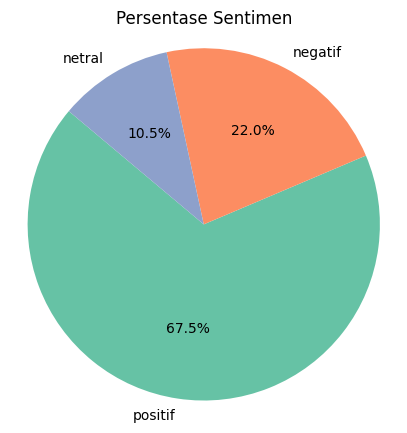

In [112]:
sentiment_counts = df['label'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.axis('equal')
plt.title('Persentase Sentimen')
plt.show()


**Visualisasi WordCloud Sentimen**

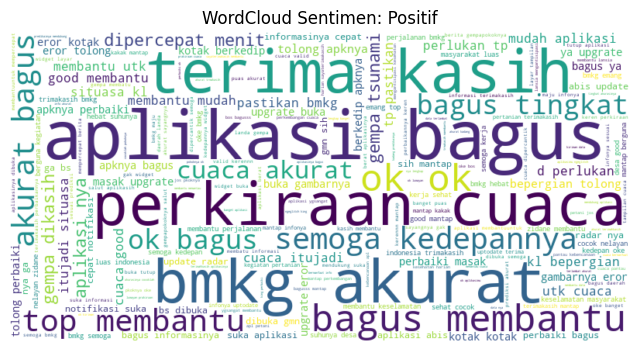

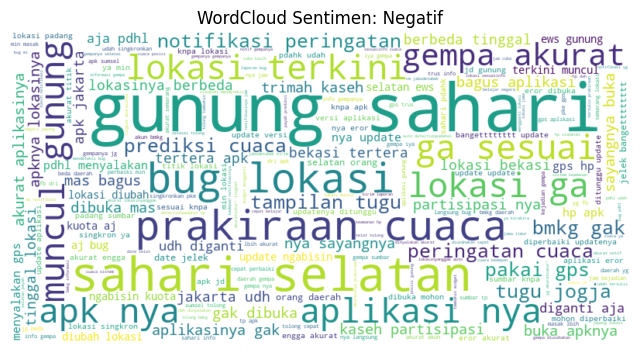

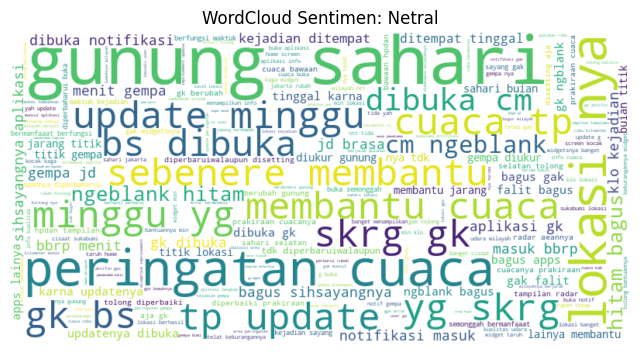

In [114]:
# Visualisasi WordCloud Sentimen untuk masing-masing label
for label in ['positif', 'negatif', 'netral']:
    plt.figure(figsize=(8, 5))
    text = ' '.join(df[df['label'] == label]['clean_content'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud Sentimen: {label.capitalize()}')
    plt.show()


## Pelatihan Model 

### Model Logistic Regression

Pada bagian ini, akan ditampilkan akurasi pada data training dan testing untuk model Logistic Regression sebagai bukti evaluasi model.

In [115]:
# Inisialisasi dan latih model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Prediksi dan evaluasi pada data training
y_train_pred = model.predict(X_train_tfidf)
train_acc = accuracy_score(y_train, y_train_pred)
print("Akurasi Training:", train_acc)

# Prediksi dan evaluasi pada data testing
y_pred = model.predict(X_test_tfidf)
test_acc = accuracy_score(y_test, y_pred)
print("Akurasi Testing:", test_acc)
print(classification_report(y_test, y_pred))


Akurasi Training: 0.98375
Akurasi Testing: 0.99
              precision    recall  f1-score   support

     negatif       0.97      1.00      0.99       132
      netral       1.00      0.97      0.98        63
     positif       1.00      0.99      0.99       405

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



**Visualisasi Confusion Matrix**

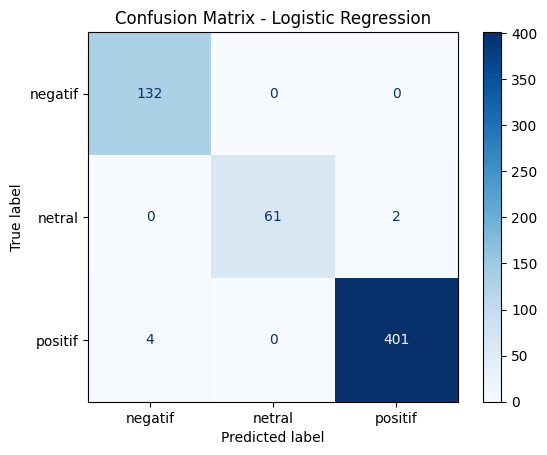

In [86]:
# Predict data uji
y_pred = model.predict(X_test_tfidf)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['negatif', 'netral', 'positif'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negatif', 'netral', 'positif'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


**Visualisasi Bar Plot: Jumlah Prediksi Tiap Label**

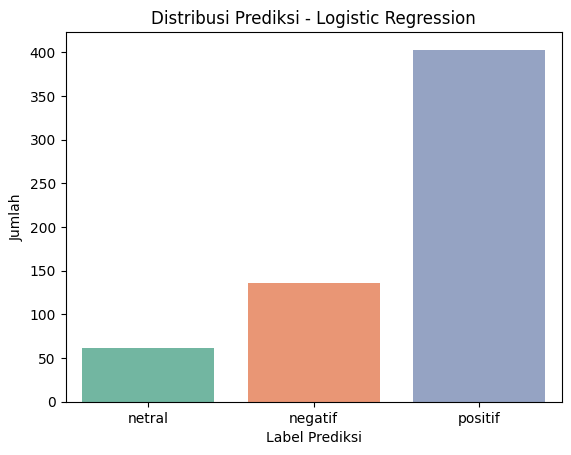

In [116]:
# Bar plot prediksi
sns.countplot(x=y_pred, palette="Set2", hue=y_pred, dodge=False)
plt.title("Distribusi Prediksi - Logistic Regression")
plt.xlabel("Label Prediksi")
plt.ylabel("Jumlah")
plt.show()


### Model SVM

Pada bagian ini, akan ditampilkan akurasi pada data training dan testing untuk model SVM sebagai bukti evaluasi model.

In [117]:
# Ulangi pembagian data (jaga konsistensi split seperti model pertama)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformasi data ke bentuk TF-IDF
X_train2_tfidf = tfidf.transform(X_train2)
X_test2_tfidf = tfidf.transform(X_test2)

# Inisialisasi dan latih model
svm_model = LinearSVC()
svm_model.fit(X_train2_tfidf, y_train2)

# Prediksi pada data training
y_train2_pred = svm_model.predict(X_train2_tfidf)
train2_acc = accuracy_score(y_train2, y_train2_pred)
print("Akurasi Training SVM:", train2_acc)

# Prediksi pada data testing
y_pred2 = svm_model.predict(X_test2_tfidf)
test2_acc = accuracy_score(y_test2, y_pred2)
print("Akurasi Testing SVM:", test2_acc)

# Evaluasi
print(classification_report(y_test2, y_pred2))


Akurasi Training SVM: 0.9845833333333334
Akurasi Testing SVM: 0.9866666666666667
              precision    recall  f1-score   support

     negatif       0.96      1.00      0.98       128
      netral       1.00      0.97      0.98        58
     positif       1.00      0.99      0.99       414

    accuracy                           0.99       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.99      0.99      0.99       600



**Visualisasi Confusion Matrix**

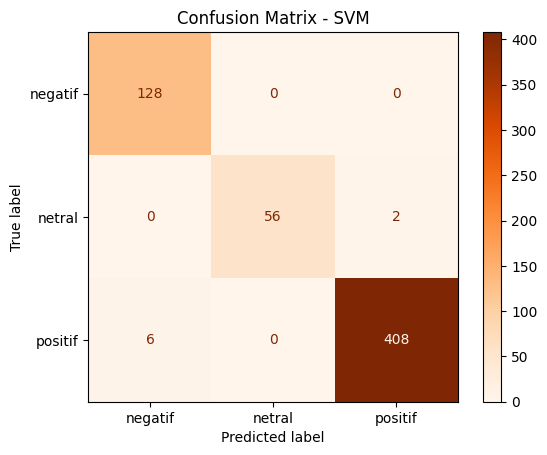

In [118]:
# Confusion matrix
cm2 = confusion_matrix(y_test2, y_pred2, labels=['negatif', 'netral', 'positif'])
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['negatif', 'netral', 'positif'])
disp2.plot(cmap='Oranges')
plt.title("Confusion Matrix - SVM")
plt.show()


**Visualisasi Bar Plot: Jumlah Prediksi Tiap Label**

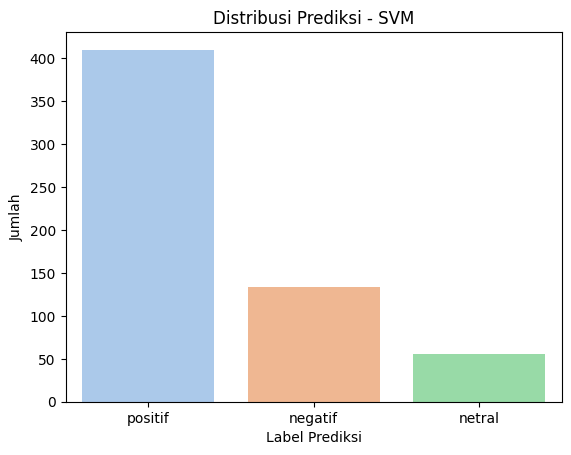

In [119]:
sns.countplot(x=y_pred2, palette="pastel", hue=y_pred2, dodge=False)
plt.title("Distribusi Prediksi - SVM")
plt.xlabel("Label Prediksi")
plt.ylabel("Jumlah")
plt.show()


### Model Random Forest

Pada bagian ini, akan ditampilkan akurasi pada data training dan testing untuk model Random Forest sebagai bukti evaluasi model.

In [123]:
# Bagi data dengan split berbeda (70:30)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.3, random_state=42)

# Transformasi data ke bentuk TF-IDF
X_train3_tfidf = tfidf.fit_transform(X_train3)
X_test3_tfidf = tfidf.transform(X_test3)

# Inisialisasi dan latih model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train3_tfidf, y_train3)

# Prediksi pada data training
y_train3_pred = rf_model.predict(X_train3_tfidf)
train3_acc = accuracy_score(y_train3, y_train3_pred)
print("Akurasi Training Random Forest:", train3_acc)

# Prediksi pada data testing
y_pred3 = rf_model.predict(X_test3_tfidf)
test3_acc = accuracy_score(y_test3, y_pred3)
print("Akurasi Testing Random Forest:", test3_acc)

# Evaluasi
print(classification_report(y_test3, y_pred3))


Akurasi Training Random Forest: 0.9871428571428571
Akurasi Testing Random Forest: 0.98
              precision    recall  f1-score   support

     negatif       0.93      1.00      0.97       199
      netral       1.00      0.96      0.98        93
     positif       0.99      0.98      0.99       608

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



**Visualisasi Confusion Matrix**

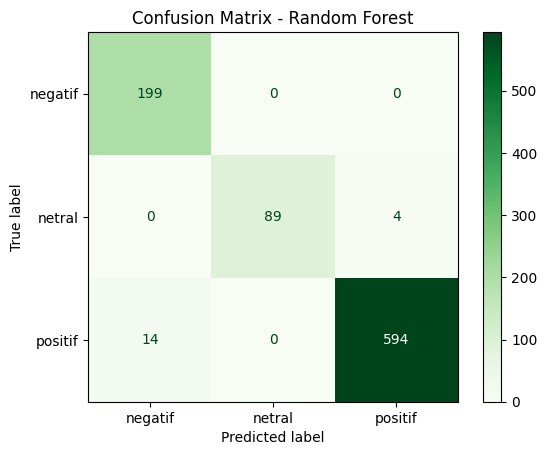

In [124]:
# Confusion matrix
cm_rf = confusion_matrix(y_test3, y_pred3, labels=['negatif', 'netral', 'positif'])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['negatif', 'netral', 'positif'])
disp_rf.plot(cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.show()


**Visualisasi Bar Plot: Jumlah Prediksi Tiap Label**

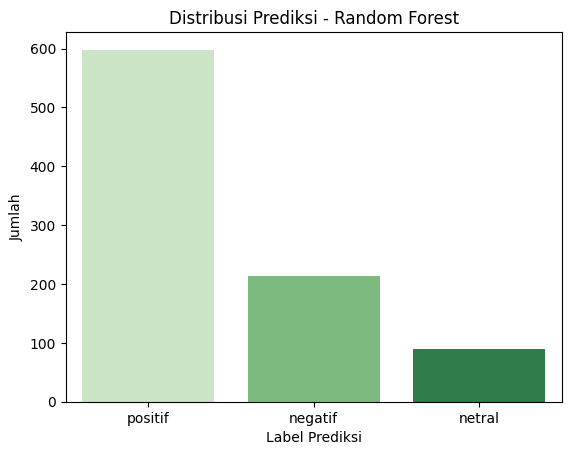

In [125]:
sns.countplot(x=y_pred3, palette="Greens", hue=y_pred3, dodge=False)
plt.title("Distribusi Prediksi - Random Forest")
plt.xlabel("Label Prediksi")
plt.ylabel("Jumlah")
plt.show()
